# Attacks using the Adversarial Robustness Toolbox (ART)

#### Attacks on a simple model using ART and Tensorflow 2.0


## Installation


In [ ]:
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt

import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("\nTensorflow Version: " + tf.__version__)
print("ART Version: " + art.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

## Training a simple model on the MNIST dataset


> If you would like to experiment with other models and datasets feel free to replace this code by whatever you need to do so. Just remember that to make the rest of the notebook work without any other major changes keep the variables train_images, train_labels, test_images, test_labels and assign them to the corresponding new data. I recommend any of the datasets offered by keras as they use the same mechanics to import them.

>Keep in mind that the MNIST dataset was used in this guide because of the little amount of time it takes to both train a good model and craft the attacks.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0 # Normalizzo le immagini tra 0.0 e 1.0
test_images = test_images / 255.0

num_classes = 10
num_samples = 100

test_images = test_images[0:num_samples]
test_labels = test_labels[0:num_samples]

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])                                                                                                       #logit è il layer che precede la softmax https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

## Implementing the FGSM attack in ART


See the documentation here: 
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm

In [12]:
# Import the attack
from art.estimators.classification import KerasClassifier # Wrapper di un modello già compilato
from art.attacks.evasion import FastGradientMethod

# Create a ART Keras classifier for the TensorFlow Keras model.
classifier = KerasClassifier(model=model, clip_values=(0, 1))

### Non-targeted (error-generic) FGSM attack
What happens if you change epsilon value?


100/100 [==============================] - 0s 96us/sample - loss: 10.5413 - accuracy: 0.0300
Accuracy on adversarial test data: 3.00%
Average perturbation: 0.06


<Figure size 432x288 with 0 Axes>

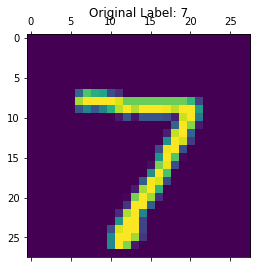

<Figure size 432x288 with 0 Axes>

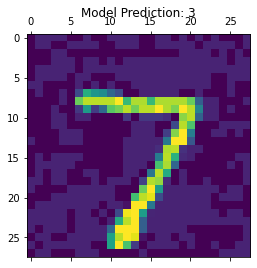

In [16]:
epsilon = 0.1 #Epsilon deve essere nel range del clip_values.

attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False) #Creo l'attacco generico (non targeted)

test_images_adv = attack.generate(test_images) #generate adversarial samples and return them in an array.

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()

### Targeted (error-specific) FGSM Attack
What happens if you change epsilon value?
What happens if you change the target?

100/100 [==============================] - 0s 115us/sample - loss: 23.7152 - accuracy: 0.0700
Accuracy on adversarial test data: 7.00%
Average perturbation: 0.12
100/100 [==============================] - 0s 246us/sample - loss: 0.4509 - accuracy: 0.9300
Targeted attack accuracy: 0.93


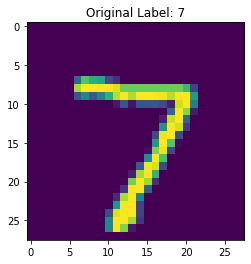

<Figure size 432x288 with 0 Axes>

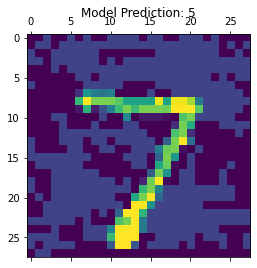

In [24]:
epsilon = 0.2
target_class = 5

attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)

# Devo Costruire una matrice del tipo (labels, samples) con valore 1 solo alla classe desiderata
targeted_labels = target_class*np.ones(test_labels.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = num_classes)
test_images_adv = attack.generate(test_images, one_hot_targeted_labels)
# ([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
#  ....
#  [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Average perturbation: {:4.2f}'.format(perturbation))

targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))

model_predictions = model.predict(test_images_adv)

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()

##Implementing BIM attack in ART

See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#basic-iterative-method-bim

In [26]:
# Import the attack
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BasicIterativeMethod

# Create a ART Keras classifier for the TensorFlow Keras model.
classifier = KerasClassifier(model=model, clip_values=(0, 1))

### Non-targeted (error-generic) BIM attack
What happens if you change epsilon value?
What happens if you change the step size for each iteration?
What happens if you change the number of iterations?

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

100/100 [==============================] - 0s 125us/sample - loss: 14.1774 - accuracy: 0.0200
Accuracy on adversarial test data: 2.00%
Average perturbation: 0.05


<Figure size 432x288 with 0 Axes>

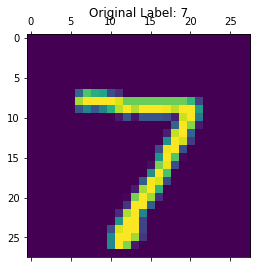

<Figure size 432x288 with 0 Axes>

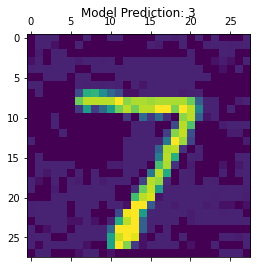

In [30]:
epsilon = 0.1
epsilon_step = 0.005
max_iter = 20

# Per l'attacco BIM si deve tener conto del fatto che vengono eseguite max_iter iterazioni quindi l'epsilon massima utilizzata e pari step*max_iter e può essere massimo epsilon
attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False)

test_images_adv = attack.generate(test_images)
 
loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()

### Targeted (error-specific) BIM attack
What happens if you change epsilon value?
What happens if you change the step size for each iteration?
What happens if you change the number of iterations?
What happens if you change the target?

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

100/100 [==============================] - 0s 105us/sample - loss: 10.8501 - accuracy: 0.1200
Accuracy on adversarial test data: 12.00%
Average perturbation: 0.05
100/100 [==============================] - 0s 115us/sample - loss: 0.2736 - accuracy: 0.9200
Targeted attack accuracy: 0.92


<Figure size 432x288 with 0 Axes>

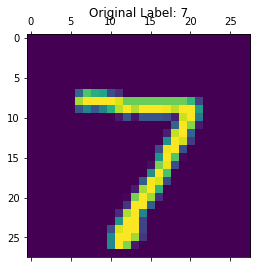

<Figure size 432x288 with 0 Axes>

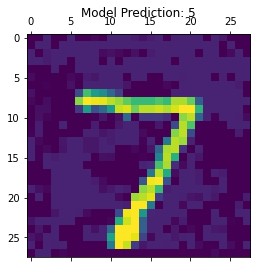

In [34]:
epsilon = 0.1
epsilon_step = 0.005
max_iter = 20
target_class = 5

attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=True)

targeted_labels = target_class*np.ones(test_labels.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = num_classes)
test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Average perturbation: {:4.2f}'.format(perturbation))
targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))

model_predictions = model.predict(test_images_adv)

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()

## Implementing PGD attack in ART

See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd

In [35]:
# Import the attack
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent

# Create a ART Keras classifier for the TensorFlow Keras model.
classifier = KerasClassifier(model=model, clip_values=(0, 1))

### Non-targeted (error-generic) PGD attack
What happens if you change epsilon value?
What happens if you change the step size for each iteration?
What happens if you change the number of iterations?

PGD - Random Initializations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

100/100 [==============================] - 0s 111us/sample - loss: 15.3093 - accuracy: 0.0200
Accuracy on adversarial test data: 2.00%
Average perturbation: 0.05


<Figure size 432x288 with 0 Axes>

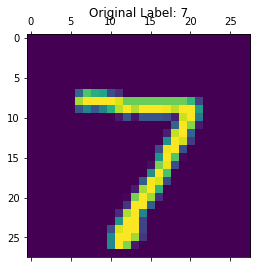

<Figure size 432x288 with 0 Axes>

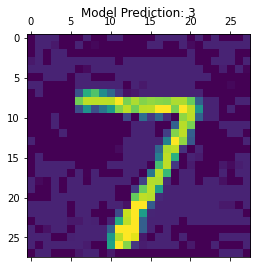

In [38]:
epsilon = 0.1
epsilon_step = 0.005
max_iter = 20
num_random_init = 5

attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init=num_random_init, targeted=False)

test_images_adv = attack.generate(test_images)

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()

### Targeted (error-specific) PGD attack
What happens if you change epsilon value?
What happens if you change the step size for each iteration?
What happens if you change the number of iterations?
What happens if you change the target?

PGD - Random Initializations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

100/100 [==============================] - 0s 91us/sample - loss: 22.5424 - accuracy: 0.1100
Accuracy on adversarial test data: 11.00%
Average perturbation: 0.18
100/100 [==============================] - 0s 83us/sample - loss: 2.2041e-05 - accuracy: 1.0000
Targeted attack accuracy: 1.00


<Figure size 432x288 with 0 Axes>

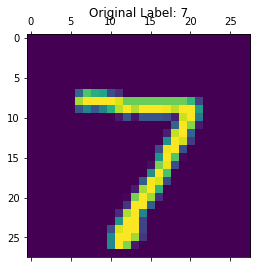

<Figure size 432x288 with 0 Axes>

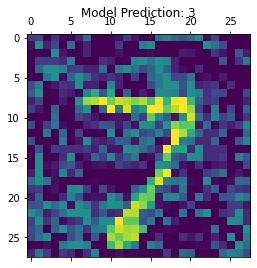

In [43]:
epsilon = 0.5
epsilon_step = 0.005
max_iter = 100
target_class = 3
num_random_init = 20

attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init = num_random_init, targeted=True)

targeted_labels = target_class*np.ones(test_labels.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = num_classes)
test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Average perturbation: {:4.2f}'.format(perturbation))
targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))

model_predictions = model.predict(test_images_adv)

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()